# Master Thesis: Machine Learning in Inflation Forecasting

Comparative Analysis of CNN-LSTM vs Statistical Models (ARIMA, SARIMA, VAR

To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.
Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.


In [1]:
# R Path - required by rpy2 prior to importing libraries
import os
import os
os.environ["R_HOME"] = "/Library/Frameworks/R.framework/Resources"
os.environ["LD_LIBRARY_PATH"] = "/Library/Frameworks/R.framework/Resources/lib/"

# Basics
import numpy as np
import pandas as pd
from datetime import datetime
import joblib
import random

# Data
from pandas_datareader.data import DataReader

# R
from rpy2.robjects import pandas2ri

# Kalman Filter
from pykalman import KalmanFilter

# Machine Learning - tensorflow, keras, and sklearn
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Flatten, Lambda, MaxPooling3D, Conv3D, RepeatVector, Layer

# SKLearn Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

# Statsmodels
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import jarque_bera
import matplotlib.dates as mdates

# Univariate GARCH

# Plots
from matplotlib import pyplot as plt
import seaborn as sns

# Misc
import warnings

from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.linear_model import LinearRegression



In [2]:

#####################################################################################################################
#                                                                                                                   #
# Data                                                                                                              #
#                                                                                                                   #
#####################################################################################################################

# Folders and worksheet names
file_path = '/Users/bodamjerry/Downloads/GermanyMacroData/'
os.chdir(file_path)
print(f"Current working directory: {os.getcwd()}")

data = pd.read_csv(
    filepath_or_buffer = file_path + 'combined' + '.csv',
    header=1,
    skiprows=[0]
)

data_desc = pd.read_csv(
    filepath_or_buffer = file_path + 'Data_Description_MD' + '.csv',
    header=0,
)

data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m', errors='coerce')
df_date = data['DATE']
data.set_index('DATE', inplace=True)

t_Data_Dir = 'TData/'

print(data.head(5))
print(data.tail(5))


Current working directory: /Users/bodamjerry/Downloads/GermanyMacroData
            UNERWG  ECBIRRO  ECBDFR  ECBMLFR  MMR   CPI  RETAILMV  RETAILXMV  \
DATE                                                                           
1999-01-01     8.9      3.0     2.0      4.5  160  73.9      83.2       83.6   
1999-02-01     8.8      3.0     2.0      4.5  130  74.0      83.1       83.5   
1999-03-01     8.8      3.0     2.0      4.5   60  74.0      83.3       83.7   
1999-04-01     8.8      2.5     1.5      3.5  700  74.4      83.5       83.9   
1999-05-01     8.6      2.5     1.5      3.5  570  74.4      83.4       83.8   

            RETAILGSR  RETAILGF  GOODFBT  AGRPROD  PPIIP   WPI   EPI   IPI  \
DATE                                                                         
1999-01-01       76.4      74.7     74.0     76.4   67.3  67.8  79.6  74.4   
1999-02-01       76.4      74.6     73.9     76.7   67.2  67.6  79.6  74.5   
1999-03-01       76.4      74.5     73.8     76.9   67.

In [3]:
print(data_desc.head())

     Transformation   Symbol  \
0  First difference   UNERWG   
1  First difference  ECBIRRO   
2  First difference   ECBDFR   
3  First difference  ECBMLFR   
4               Log      MMR   

                                         Description  
0  Unemployment registered pursuant to section 16...  
1  ECB interest rates for main refinancing operat...  
2  ECB's deposit facility rate / End of month / S...  
3  ECB's marginal lending facility rate / End of ...  
4  Money market rates / EURIBOR (R) One-month mon...  


In [4]:
all_columns = set(data.columns)
print(all_columns)
print(len(all_columns))
df = data.copy()
df.dropna(inplace=True)


{'IPI', 'MMR', 'CPI', 'RETAILGF', 'UNERWG', 'UR', 'AGRPROD', 'ECBIRRO', 'HICP', 'RETAILXMV', 'PPIIP', 'WPI', 'RETAILGSR', 'RETAILMV', 'EPI', 'ECBMLFR', 'GOODFBT', 'LTIR', 'ECBDFR'}
19


# Log Transformation

Performing log transformation. 
Candidate Series with zero values - zeroes are replaced with 0.001 to allow for logging and as well reduce the effect.

In [5]:
# Columns to be logged
non_rate_cols = ['MMR', 'CPI', 'RETAILMV', 'RETAILXMV', 'RETAILGSR', 'RETAILGF', 'GOODFBT',	'AGRPROD',	'PPIIP', 'WPI',	'EPI', 'IPI']


In [6]:

# Identify column with zero and replace with 0.001
df_lt = df.copy()
for col in non_rate_cols:
    if (df[col] == 0).any():
        df_lt[col] = df_lt[col].replace(0, 0.001)

# Apply log transformation
for col in non_rate_cols:
    df_lt[col] = np.log(df_lt[col])

print(df_lt.head(5))
print(df_lt.tail(5))


            UNERWG  ECBIRRO  ECBDFR  ECBMLFR       MMR       CPI  RETAILMV  \
DATE                                                                         
1999-01-01     8.9      3.0     2.0      4.5  5.075174  4.302713  4.421247   
1999-02-01     8.8      3.0     2.0      4.5  4.867534  4.304065  4.420045   
1999-03-01     8.8      3.0     2.0      4.5  4.094345  4.304065  4.422449   
1999-04-01     8.8      2.5     1.5      3.5  6.551080  4.309456  4.424847   
1999-05-01     8.6      2.5     1.5      3.5  6.345636  4.309456  4.423648   

            RETAILXMV  RETAILGSR  RETAILGF   GOODFBT   AGRPROD     PPIIP  \
DATE                                                                       
1999-01-01   4.426044   4.335983  4.313480  4.304065  4.335983  4.209160   
1999-02-01   4.424847   4.335983  4.312141  4.302713  4.339902  4.207673   
1999-03-01   4.427239   4.335983  4.310799  4.301359  4.342506  4.207673   
1999-04-01   4.429626   4.335983  4.312141  4.302713  4.330733  4.213608 

# Testing Stationarity & Differencing

In [7]:
def test_stationarity_adf(series, col, alpha=0.05):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f' {key}: {value}')
        
    is_stationary = result[1] < alpha
    print('Series:', col, is_stationary)
    return is_stationary

def test_stationarity_kpss(series, col, alpha=0.05):
    kpss_result = kpss(series, regression='c', nlags='auto')
    print('KPSS Statistic:', kpss_result[0])
    print('p-value:', kpss_result[1])
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print(f' {key}: {value}') 
    is_stationary = kpss_result[1] >= alpha  # KPSS NULL = stationary
    print('Series:', col, is_stationary)
    return is_stationary

def test_stationarity_adf_kpss(series, name, alpha=0.05):
    # ADF Test
    adf_result = adfuller(series, autolag='AIC')
    # KPSS Test
    kpss_result = kpss(series, regression='c', nlags='auto')

    # Interpret results
    is_stationary_adf = adf_result[1] < alpha
    is_stationary_kpss = kpss_result[1] >= alpha  # KPSS NULL = stationary

    print(f"Results for {name}:")
    print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}, Stationary: {is_stationary_adf}")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}, p-value: {kpss_result[1]:.4f}, Stationary: {is_stationary_kpss}")
    # To avoid overdifferencing, we use ADF
    return is_stationary_kpss


In [8]:

def plot_series(series, df_date=None, title='Time Series'):
    plt.figure(figsize=(12, 6))
    if df_date is not None:
        # plt.plot(df_date, series, label='Time Series')
        plt.plot(df_date, series, label='Time Series')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format
    else:
        plt.plot(series, label='Time Series')
    plt.title(title)
    plt.xlabel('Date' if df_date is not None else 'Time')
    plt.ylabel('Value')
    plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
    plt.legend()
    plt.tight_layout()       # Adjust layout to prevent clipping
    plt.show()

def difference(series):
    return series.diff().dropna()

def plot_grid_series(data, column_names=None, grid_rows=4, grid_cols=3, figsize=(18, 14)):
    """
    Plots time series for multiple columns in a DataFrame in a grid layout.

    Args:
        data (pd.DataFrame): DataFrame containing time series data.
        column_names (list, optional): List of column names to plot.
                                        If None, all columns in data are plotted. Defaults to None.
        grid_rows (int, optional): Number of rows in the subplot grid. Defaults to 4.
        grid_cols (int, optional): Number of columns in the subplot grid. Defaults to 3.
        figsize (tuple, optional): Figure size for the entire grid plot. Defaults to (18, 14).
    """

    if column_names is None:
        column_names = data.columns

    num_plots = len(column_names)
    fig, axes = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=figsize)
    axes = axes.flatten() # Flatten the 2D array of axes to easily iterate

    for i, col_name in enumerate(column_names):
        series = data[col_name]
        ax = axes[i] # Get the current subplot axes

        # --- Ensure series.index is a DateTimeIndex ---
        if not isinstance(series.index, pd.DatetimeIndex):
            try:
                series.index = pd.to_datetime(series.index)
            except ValueError:
                print(f"Warning: Series index for {col_name} not in DateTime format. Plotting without date formatting.")
                ax.plot(series.values, label=col_name, color='#2b8cbe', linestyle='-', linewidth=1.5)
                ax.set_title(col_name, fontsize=14) # Smaller subplot title font
                ax.set_xlabel('Time', fontsize=10)   # Smaller subplot xlabel font
                ax.set_ylabel('Value', fontsize=10)  # Smaller subplot ylabel font
                ax.tick_params(axis='x', rotation=45, labelsize=8) # Smaller tick label font
                ax.grid(True, linestyle='--', alpha=0.5, color='gray')
                ax.legend(fontsize='small', frameon=True, edgecolor='black')
                continue # Skip date formatting for this subplot

        ax.plot(series.index, series.values, label=col_name, color='#2b8cbe', linestyle='-', linewidth=1.5)

        # --- Date Locator and Formatter for each subplot ---
        locator = mdates.AutoDateLocator()
        ax.xaxis.set_major_locator(locator)
        formatter = mdates.DateFormatter('%Y-%m')
        ax.xaxis.set_major_formatter(formatter)

        ax.set_title(col_name, fontsize=14) # Smaller subplot title font
        ax.set_xlabel('Date', fontsize=10)   # Smaller subplot xlabel font
        ax.set_ylabel('Value', fontsize=10)  # Smaller subplot ylabel font

        ax.tick_params(axis='x', rotation=45, labelsize=8) # Smaller tick label font
        ax.grid(True, linestyle='--', alpha=0.5, color='gray')
        ax.legend(fontsize='small', frameon=True, edgecolor='black')

        # --- Customize Spines for each subplot ---
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.spines['left'].set_linewidth(0.5)

    # Remove any unused subplots if num_plots is less than grid_rows * grid_cols
    for j in range(num_plots, grid_rows * grid_cols):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout for better spacing, make room for suptitle
    plt.suptitle('Time Series Grid', fontsize=18) # Overall title for the grid
    plt.show()


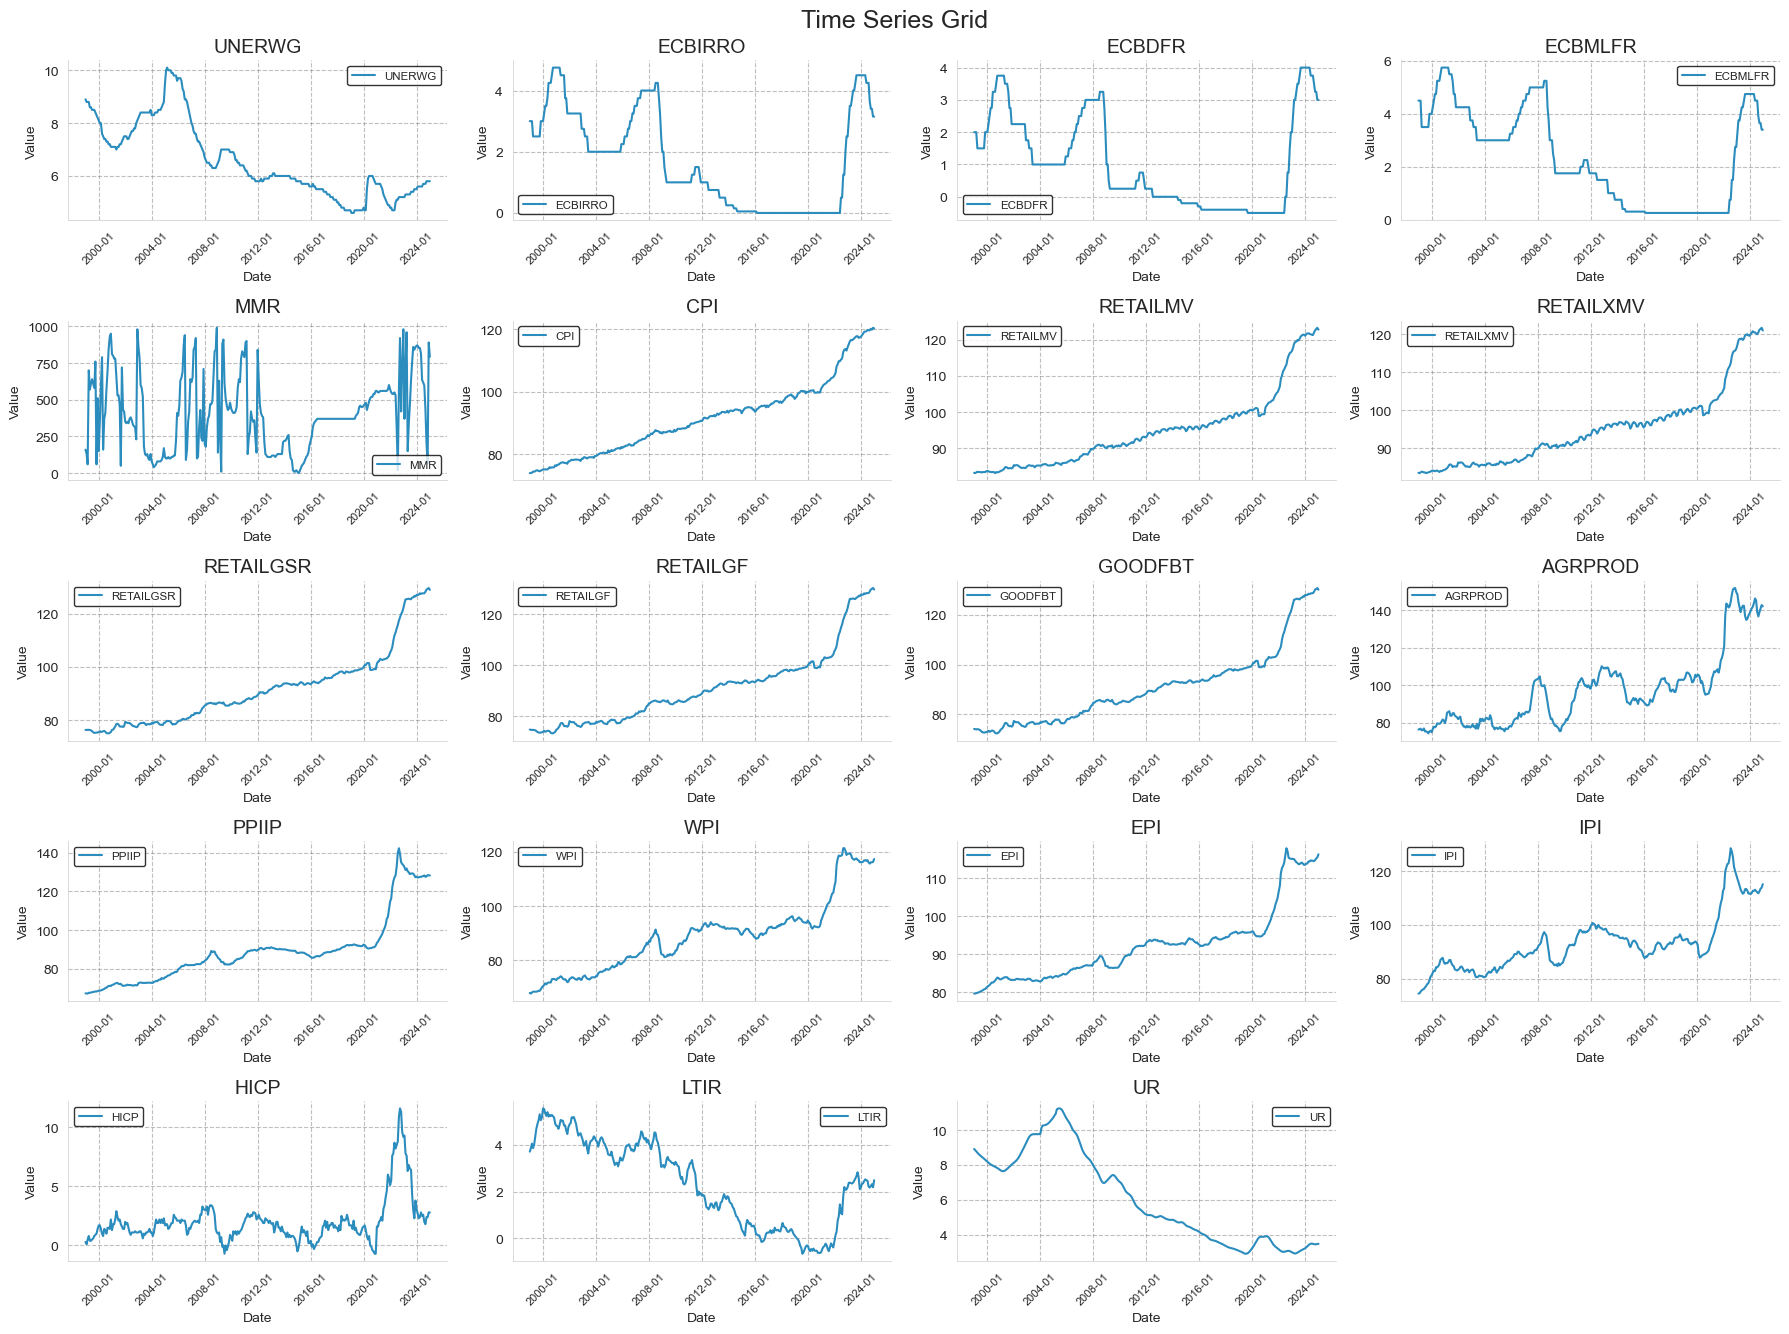

In [9]:
# --- Initial Plot ---
plot_grid_series(df, grid_rows=5, grid_cols=4) # Plots all columns in a 4x3 grid (default)

In [10]:
non_stationary_series = []

for i in all_columns:
    series = pd.to_numeric(df_lt[i], errors='coerce')
    is_stationary = test_stationarity_adf_kpss(series, i)
    if not is_stationary:
        non_stationary_series.append(i)


Results for IPI:
ADF Statistic: -1.7290, p-value: 0.4163, Stationary: False
KPSS Statistic: 1.7945, p-value: 0.0100, Stationary: False
Results for MMR:
ADF Statistic: -4.6617, p-value: 0.0001, Stationary: True
KPSS Statistic: 0.1959, p-value: 0.1000, Stationary: True
Results for CPI:
ADF Statistic: 0.5126, p-value: 0.9853, Stationary: False
KPSS Statistic: 2.5728, p-value: 0.0100, Stationary: False
Results for RETAILGF:
ADF Statistic: 0.2440, p-value: 0.9746, Stationary: False
KPSS Statistic: 2.4605, p-value: 0.0100, Stationary: False
Results for UNERWG:
ADF Statistic: -1.7602, p-value: 0.4004, Stationary: False
KPSS Statistic: 2.0736, p-value: 0.0100, Stationary: False
Results for UR:
ADF Statistic: -0.9514, p-value: 0.7706, Stationary: False
KPSS Statistic: 2.3552, p-value: 0.0100, Stationary: False
Results for AGRPROD:
ADF Statistic: -0.7674, p-value: 0.8285, Stationary: False
KPSS Statistic: 1.9864, p-value: 0.0100, Stationary: False
Results for ECBIRRO:
ADF Statistic: -2.2110, p-v

/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/4145966236.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/4145966236.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/4145966236.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/41459662

In [11]:
print("NON Stationary Series:")
print(non_stationary_series)

first_diff = ["UNERWG",
 "ECBIRRO",
 "ECBDFR",
 "ECBMLFR",
 "CPI",
 "RETAILMV",
 "RETAILXMV",
 "RETAILGSR",
 "RETAILGF",
 "GOODFBT",
 "AGRPROD",
 "PPIIP",
 "WPI",
 "EPI",
 "IPI",
 "LTIR",
 "UR"]

NON Stationary Series:
['IPI', 'CPI', 'RETAILGF', 'UNERWG', 'UR', 'AGRPROD', 'ECBIRRO', 'HICP', 'RETAILXMV', 'PPIIP', 'WPI', 'RETAILGSR', 'RETAILMV', 'EPI', 'ECBMLFR', 'GOODFBT', 'LTIR', 'ECBDFR']


# First Differencing

In [12]:
df_lts = df_lt.copy()
second_non_stationary_series = []
# for col in non_stationary_series:
for col in non_stationary_series:
    df_series = df_lts[col].diff().dropna()
    df_lts[col] = df_series
    # Check if it's now stationary
    if not test_stationarity_adf_kpss(df_series, col + " (log-diffed)"):
        second_non_stationary_series.append(col)
df_lts.dropna(inplace=True)

Results for IPI (log-diffed):
ADF Statistic: -5.1817, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0571, p-value: 0.1000, Stationary: True
Results for CPI (log-diffed):
ADF Statistic: -2.9964, p-value: 0.0352, Stationary: True
KPSS Statistic: 0.4826, p-value: 0.0456, Stationary: False
Results for RETAILGF (log-diffed):
ADF Statistic: -2.9916, p-value: 0.0357, Stationary: True
KPSS Statistic: 0.5098, p-value: 0.0395, Stationary: False
Results for UNERWG (log-diffed):
ADF Statistic: -6.8479, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.1200, p-value: 0.1000, Stationary: True
Results for UR (log-diffed):
ADF Statistic: -2.7588, p-value: 0.0644, Stationary: False
KPSS Statistic: 0.1791, p-value: 0.1000, Stationary: True
Results for AGRPROD (log-diffed):
ADF Statistic: -11.7833, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0684, p-value: 0.1000, Stationary: True
Results for ECBIRRO (log-diffed):
ADF Statistic: -5.1615, p-value: 0.0000, Stationary: True
KPSS Statistic: 0

/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/4145966236.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/4145966236.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/4145966236.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/41459662

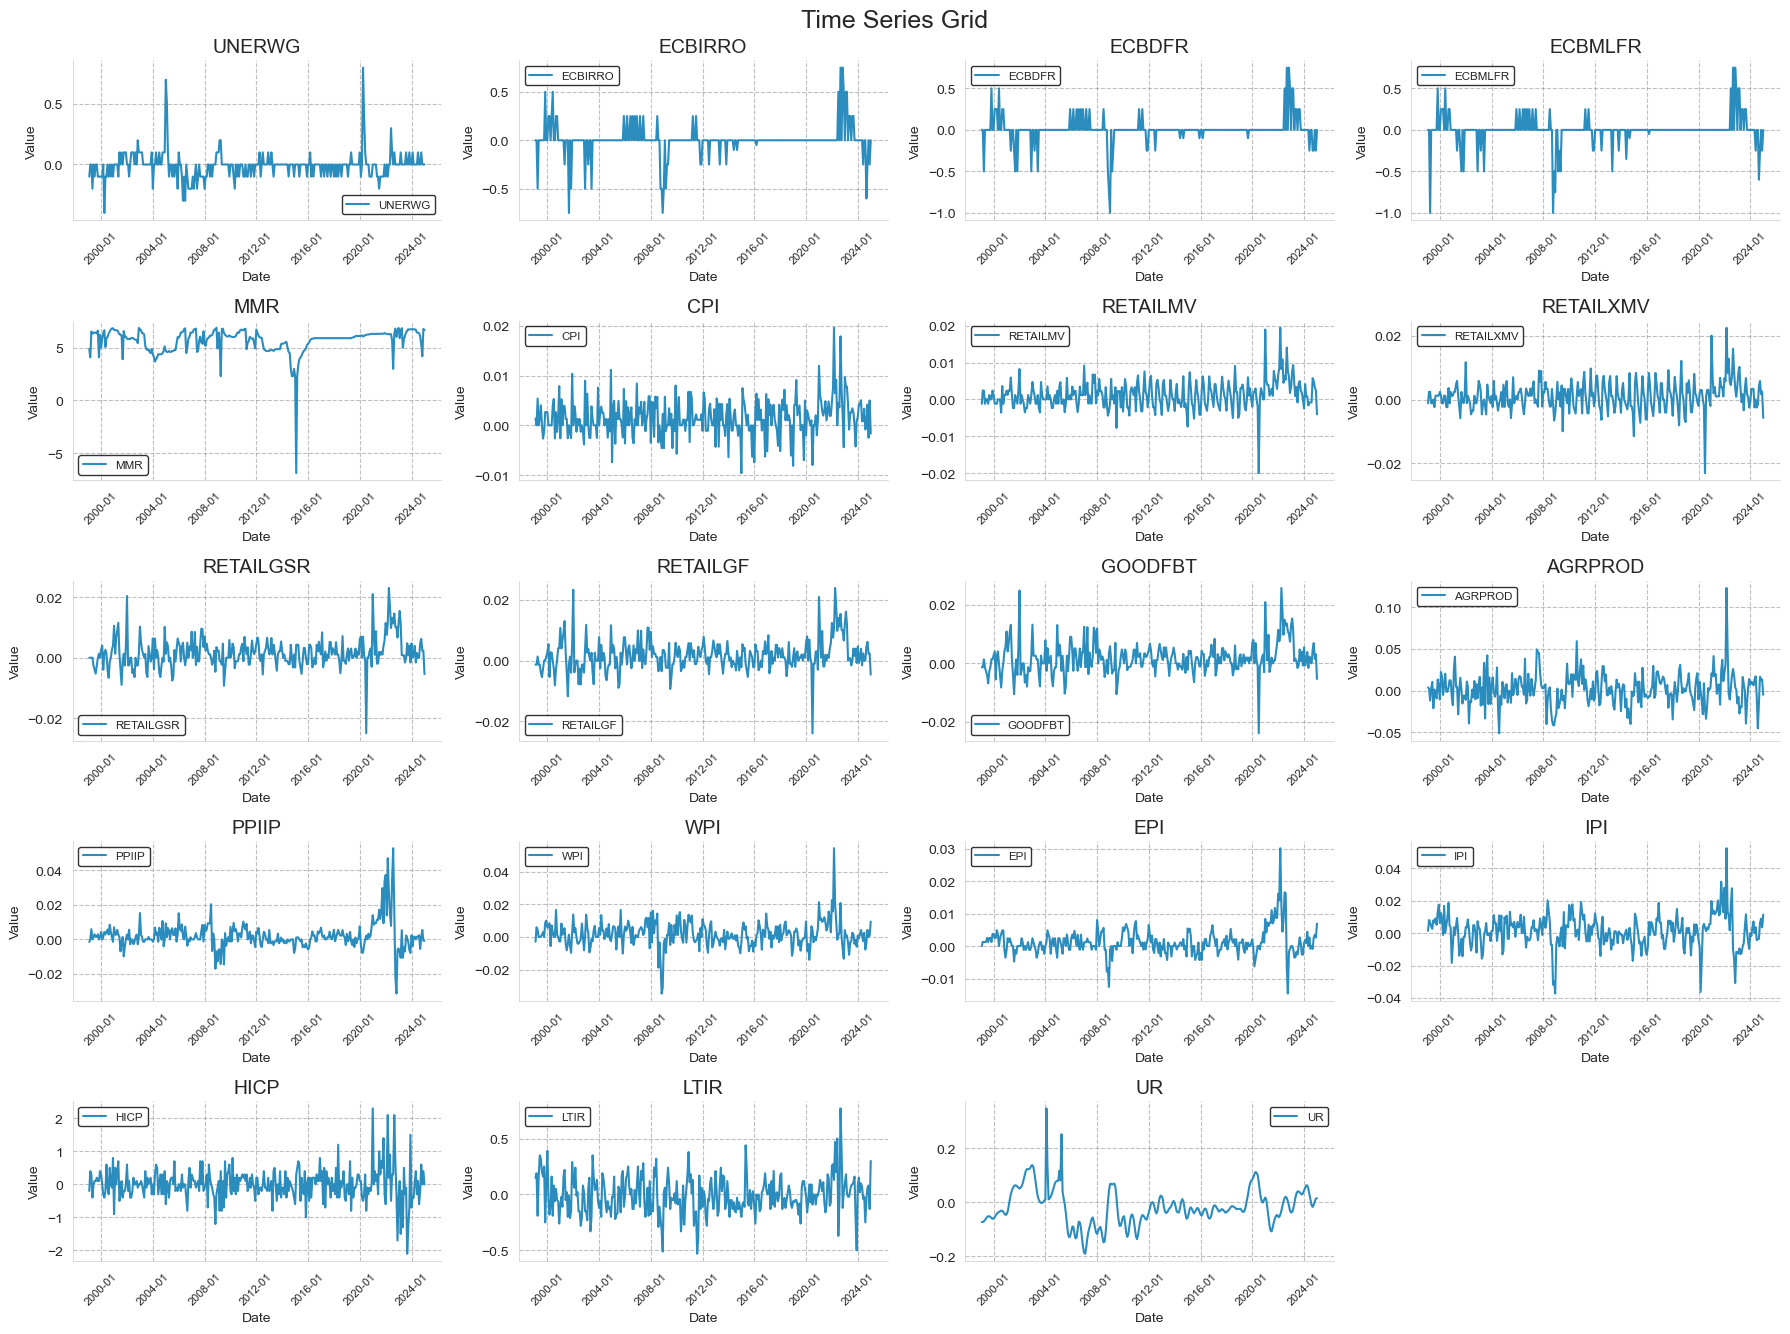

In [13]:
# --- First Plot After Differencing ---
plot_grid_series(df_lts, grid_rows=5, grid_cols=4) # Plots all columns in a 4x3 grid (default)

# Second Differencing

In [14]:
print("NON Stationary Series after First Difference:")
print(second_non_stationary_series)

second_diff = ['RETAILMV', 'RETAILXMV']

NON Stationary Series after First Difference:
['CPI', 'RETAILGF', 'RETAILXMV', 'RETAILGSR', 'RETAILMV', 'GOODFBT']


In [15]:
third_non_stationary_series = []
df_ltss = df_lts

# for col in second_non_stationary_series:
for col in second_non_stationary_series:
    df_series = df_ltss[col].diff().dropna()
    df_ltss[col] = df_series
    # Check if it's now stationary
    if not test_stationarity_adf_kpss(df_series, col + " (log-diffed)"):
        third_non_stationary_series.append(col)

df_ltss.dropna(inplace=True)


Results for CPI (log-diffed):
ADF Statistic: -14.2493, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.2241, p-value: 0.1000, Stationary: True
Results for RETAILGF (log-diffed):
ADF Statistic: -8.5341, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0462, p-value: 0.1000, Stationary: True
Results for RETAILXMV (log-diffed):
ADF Statistic: -12.1652, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.1237, p-value: 0.1000, Stationary: True
Results for RETAILGSR (log-diffed):
ADF Statistic: -8.5080, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0645, p-value: 0.1000, Stationary: True
Results for RETAILMV (log-diffed):
ADF Statistic: -11.7136, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.1207, p-value: 0.1000, Stationary: True
Results for GOODFBT (log-diffed):
ADF Statistic: -8.5131, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0499, p-value: 0.1000, Stationary: True


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/4145966236.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/4145966236.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/4145966236.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/41459662

In [16]:
print("NON Stationary Series after Second Difference:")
print(third_non_stationary_series)

NON Stationary Series after Second Difference:
[]


Transformation Based on Mckracken & Ng

In [17]:
qty_series = df.shape[1]
print(qty_series)


19


In [18]:
# str_transf = data_desc.iloc[i,0]
# str_ticker = data_desc.iloc[i,2]
# 
# print(str_transf)
# print(str_ticker)

In [19]:

# for i in range(0,qty_series):
#     str_transf = data_desc.iloc[i,2]
#     str_ticker = df_FRED_Desc_MD.iloc[i,3]
#     col_ticker = np.where(df_FRED_MD_t.columns == str_ticker)
#     if len(col_ticker[0]) > 0:
#         col_ticker = col_ticker[0][0]
#         df_series = df_FRED_MD_t.iloc[:,col_ticker]
#         if str_transf == "First difference of log":
#             df_FRED_MD_t.iloc[:,col_ticker] = np.log(df_series).diff()
#         elif str_transf == "First difference":
#             df_FRED_MD_t.iloc[:,col_ticker] = df_series.diff()
#         elif str_transf == "Log":
#             df_FRED_MD_t.iloc[:,col_ticker] = np.log(df_series)
#         elif str_transf == "Second difference of log":
#             df_FRED_MD_t.iloc[:,col_ticker] = np.log(df_series).diff().diff()
#         elif str_transf == "Second difference":
#             df_FRED_MD_t.iloc[:,col_ticker] = df_series.diff().diff()
#         elif str_transf == "First difference of (ratio - 1)":
#             df_FRED_MD_t.iloc[:,col_ticker] = df_series.pct_change().diff()
# 
# 
# print(df_FRED_MD_t['S&P 500'].head())
# print(df_FRED_MD_t['S&P 500'].tail())

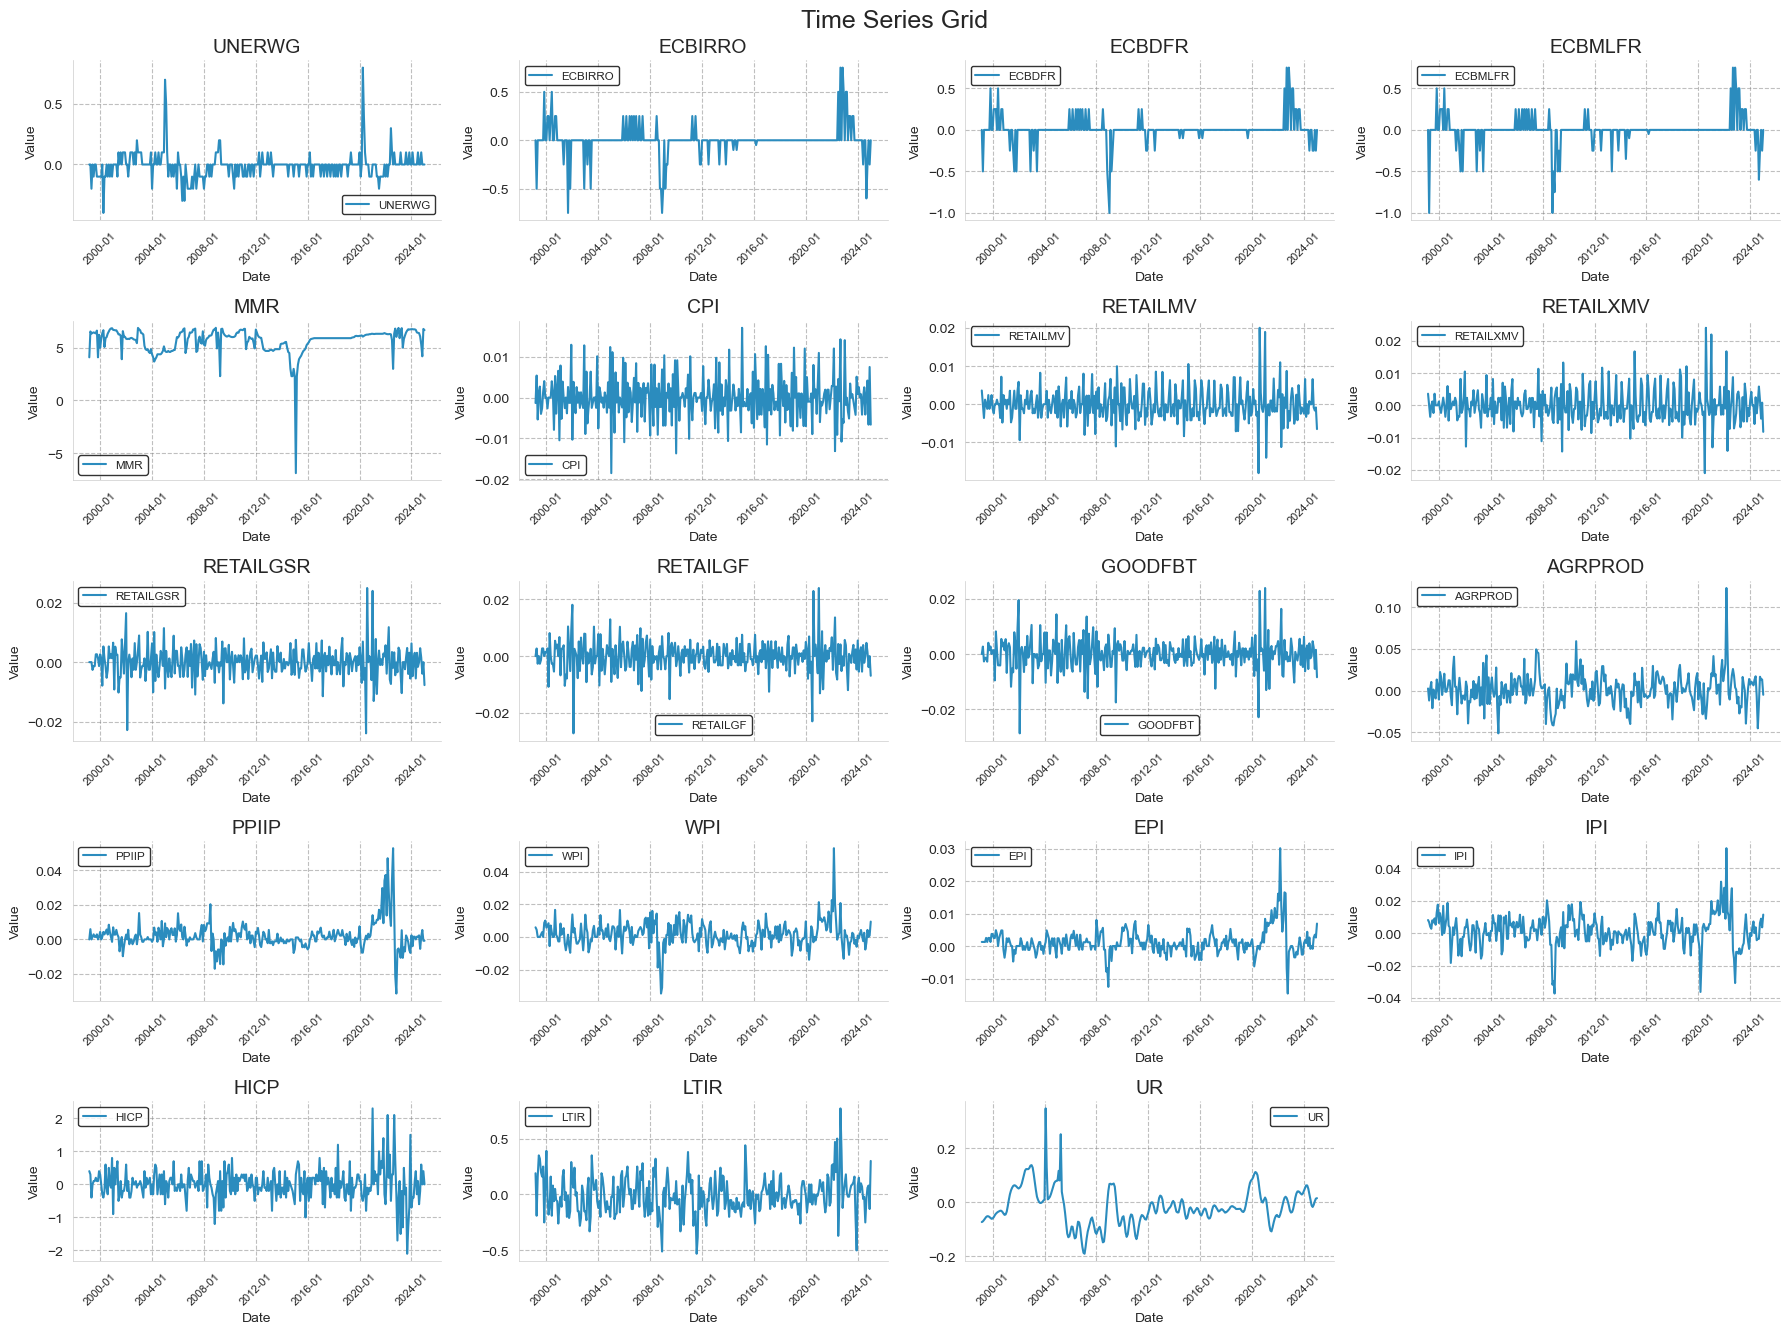

In [20]:
# --- Second Plot After Second Differencing ---
plot_grid_series(df_ltss, grid_rows=5, grid_cols=4) # Plots all columns in a 4x3 grid (default)


# Descriptive Statistics of the CPI & HICP

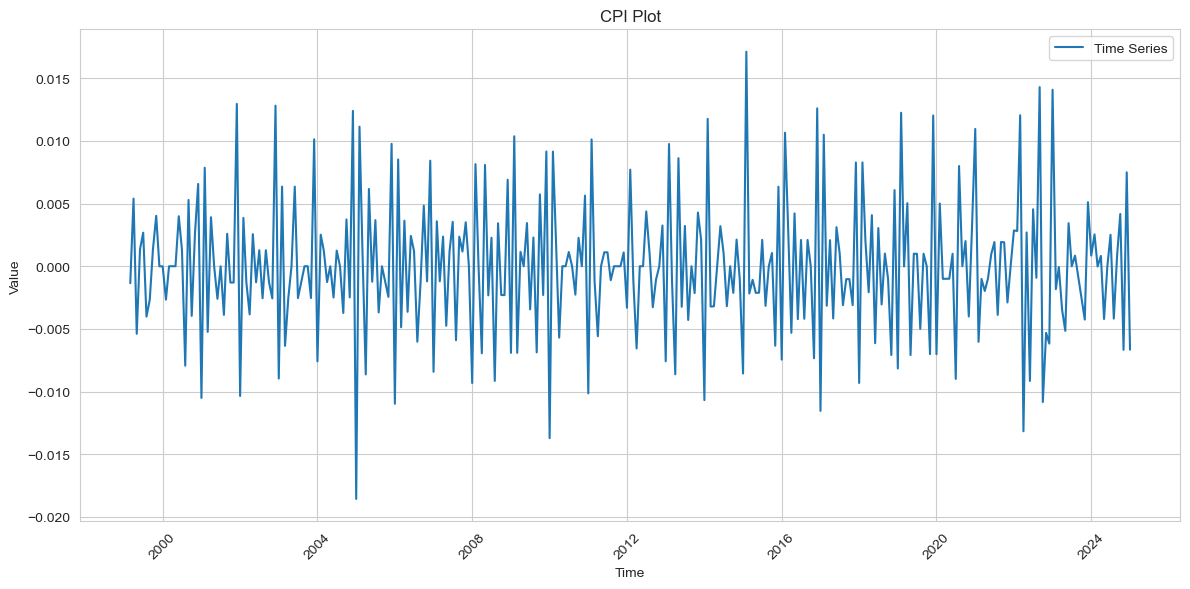

ADF Statistic: -14.249262473714108
p-value: 1.4908152294297964e-26
Critical Values:
 1%: -3.4523371197407404
 5%: -2.871222860740741
 10%: -2.571929211111111
Series: CPI True
Stationary?
True


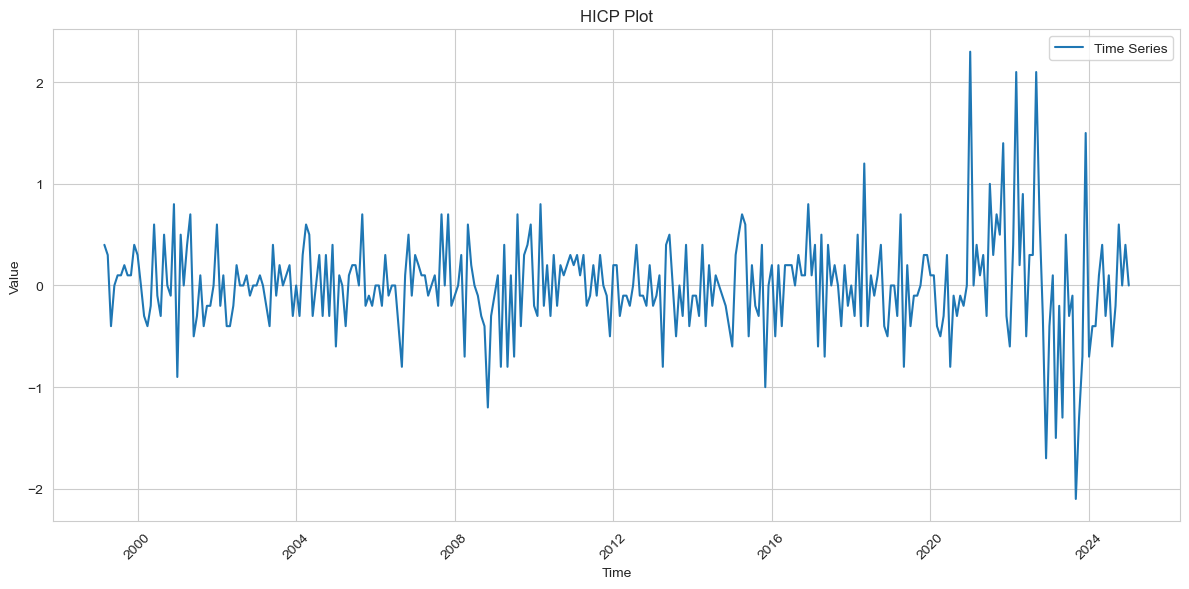

ADF Statistic: -4.4798934338281375
p-value: 0.00021376076277335312
Critical Values:
 1%: -3.4525611751768914
 5%: -2.87132117782556
 10%: -2.5719816428028888
Series: HICP True
Stationary?
True


In [21]:
cpi_series = df_ltss['CPI']
plot_series(cpi_series, title="CPI Plot")
result = test_stationarity_adf(cpi_series, "CPI")
print("Stationary?")
print(result)

hicp_series = df_ltss['HICP']
plot_series(hicp_series, title="HICP Plot")
result2 = test_stationarity_adf(hicp_series, "HICP")
print("Stationary?")
print(result2)


In [22]:
# Usage
test_stationarity_kpss(cpi_series, "CPI")
test_stationarity_kpss(hicp_series, "HICP")


KPSS Statistic: 0.22414504016194137
p-value: 0.1
Critical Values:
 10%: 0.347
 5%: 0.463
 2.5%: 0.574
 1%: 0.739
Series: CPI True
KPSS Statistic: 0.04415413289153596
p-value: 0.1
Critical Values:
 10%: 0.347
 5%: 0.463
 2.5%: 0.574
 1%: 0.739
Series: HICP True


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/4145966236.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_23583/4145966236.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


True

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


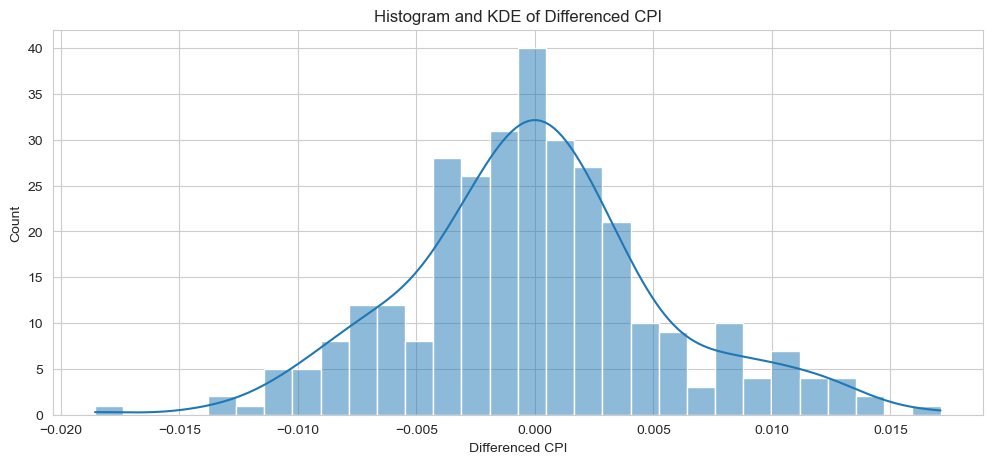

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


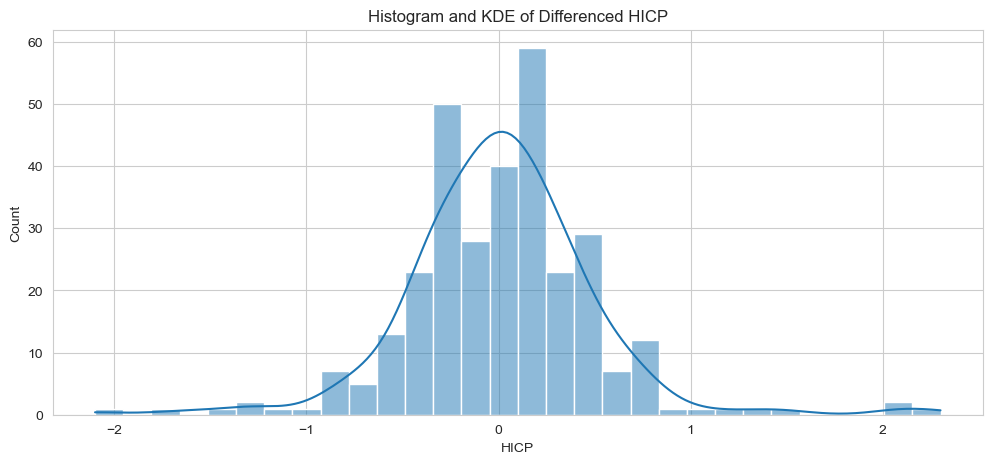

In [23]:

plt.figure(figsize=(12, 5))
sns.histplot(cpi_series, kde=True, bins=30)
plt.title('Histogram and KDE of Differenced CPI')
plt.xlabel('Differenced CPI')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(hicp_series, kde=True, bins=30)
plt.title('Histogram and KDE of Differenced HICP')
plt.xlabel('HICP')
plt.grid(True)
plt.show()


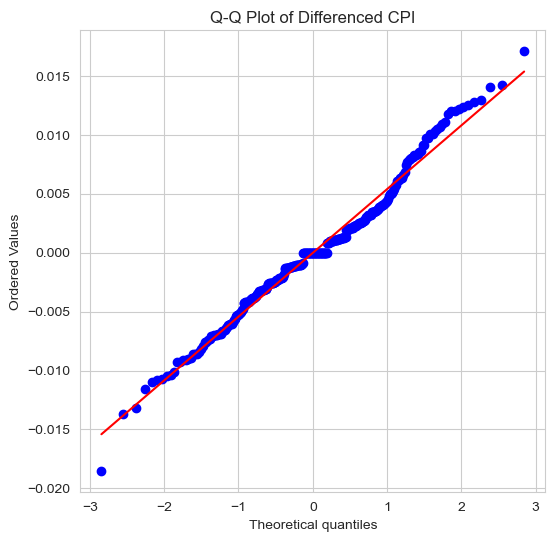

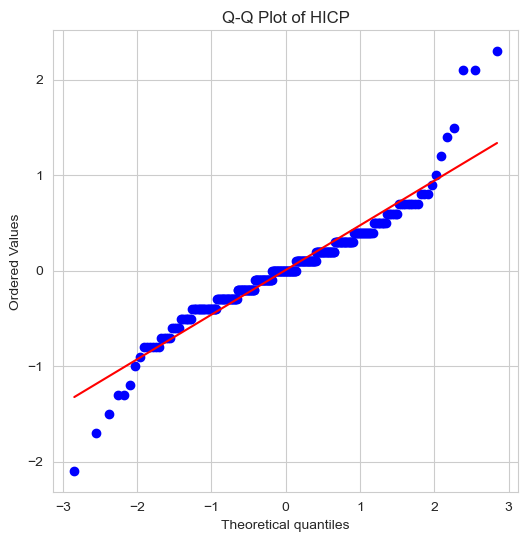

In [24]:
import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(cpi_series, dist="norm", plot=plt)
plt.title("Q-Q Plot of Differenced CPI")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(hicp_series, dist="norm", plot=plt)
plt.title("Q-Q Plot of HICP")
plt.grid(True)
plt.show()


In [25]:

# Perform Jarque-Bera test
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(cpi_series)

print("Jarque-Bera Test Statistic:", jb_stat)
print("p-value:", jb_pvalue)
print("Skewness:", skew)
print("Kurtosis:", kurtosis)

# Interpretation
if jb_pvalue > 0.05:
    print("The CPI residuals are likely normally distributed (fail to reject H0).")
else:
    print("The CPI residuals are not normally distributed (reject H0).")


Jarque-Bera Test Statistic: 6.351296772100624
p-value: 0.04176701415416162
Skewness: 0.20482345581944564
Kurtosis: 3.5677337708562162
The CPI residuals are not normally distributed (reject H0).


In [26]:

# Perform Jarque-Bera test
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(hicp_series)

print("Jarque-Bera Test Statistic:", jb_stat)
print("p-value:", jb_pvalue)
print("Skewness:", skew)
print("Kurtosis:", kurtosis)

# Interpretation
if jb_pvalue > 0.05:
    print("The HICP residuals are likely normally distributed (fail to reject H0).")
else:
    print("The HICP residuals are not normally distributed (reject H0).")


Jarque-Bera Test Statistic: 301.240556598801
p-value: 3.8587289365778245e-66
Skewness: 0.3739390328990934
Kurtosis: 7.763143717327594
The HICP residuals are not normally distributed (reject H0).


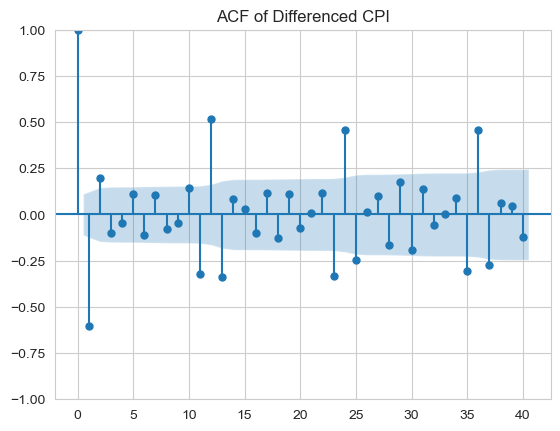

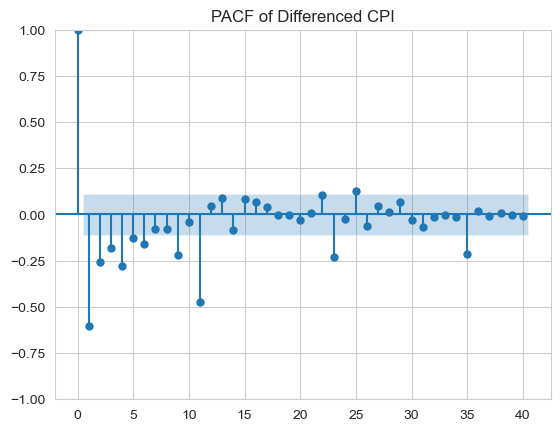

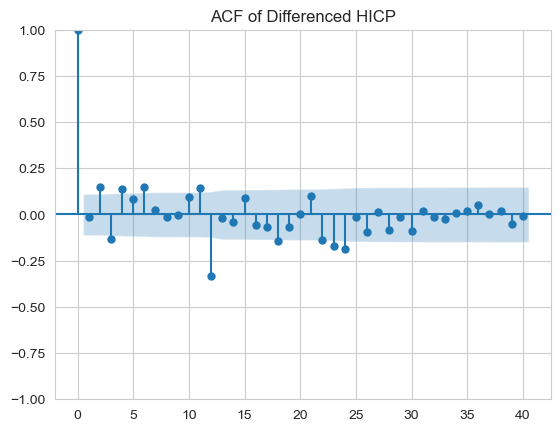

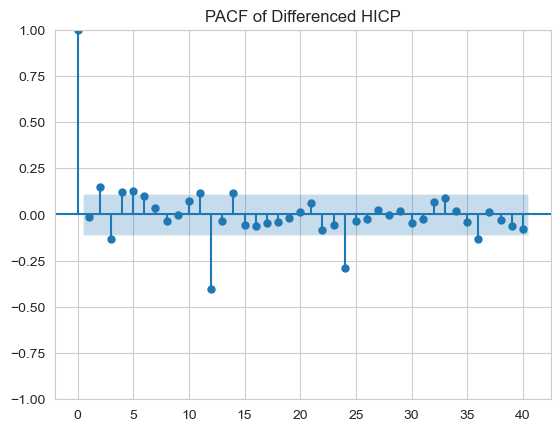

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(cpi_series, lags=40)
plt.title("ACF of Differenced CPI")
plt.show()

plot_pacf(cpi_series, lags=40, method='ywm')
plt.title("PACF of Differenced CPI")
plt.show()

plot_acf(hicp_series, lags=40)
plt.title("ACF of Differenced HICP")
plt.show()

plot_pacf(hicp_series, lags=40, method='ywm')
plt.title("PACF of Differenced HICP")
plt.show()


In [28]:
# df_series = df_ltss['HICP'].diff().dropna()
# df_ltss['HICP'] = df_series

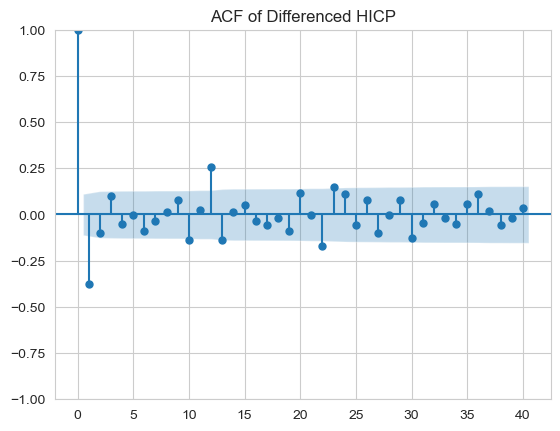

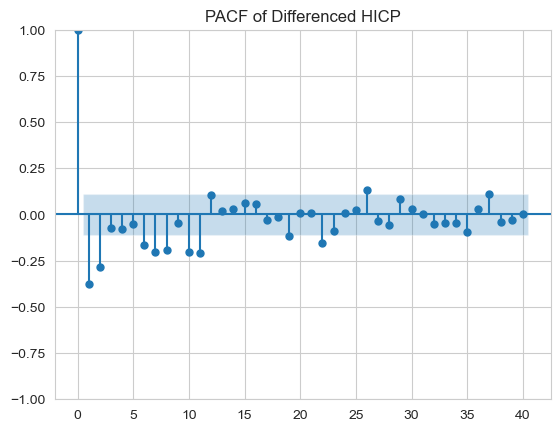

In [29]:
plot_acf(df_series, lags=40)
plt.title("ACF of Differenced HICP")
plt.show()

plot_pacf(df_series, lags=40, method='ywm')
plt.title("PACF of Differenced HICP")
plt.show()

# Creating 100 Random State

In [30]:
r_State_Dir = "RState/"
all_LagsHICP_Dir = "AllLagsHICP/"
all_LagsCPI_Dir = "AllLagsCPI/"
all_LagsNonNormCPI_Dir = "AllLagsNNCPI/"
all_LagsNonNormHICP_Dir = "AllLagsNNHICP/"


In [31]:
print(df_ltss.columns)

Index(['UNERWG', 'ECBIRRO', 'ECBDFR', 'ECBMLFR', 'MMR', 'CPI', 'RETAILMV',
       'RETAILXMV', 'RETAILGSR', 'RETAILGF', 'GOODFBT', 'AGRPROD', 'PPIIP',
       'WPI', 'EPI', 'IPI', 'HICP', 'LTIR', 'UR'],
      dtype='object')


In [32]:

# Define the number of rolling splits you want to create
# -----------------------------
# CONFIGURATION
# -----------------------------
num_splits = 100
sample_size = len(df_ltss) - num_splits - 13

fixed_test_size = int(sample_size * 0.2)
fixed_train_size = sample_size - fixed_test_size

print(fixed_train_size)
print(fixed_test_size)
print(sample_size)


159
39
198


In [33]:
scaler = StandardScaler()
df_ltsx = pd.DataFrame(scale(df_ltss), index=df_ltss.index, columns=df_ltss.columns)

# --- Rolling Split Generation ---
total_len = len(df_ltsx) # Use the length of the original data
window_size = fixed_train_size + fixed_test_size # 169 + 42 = 211
filepath_scaled = os.path.join(t_Data_Dir, "data_scaled.csv")
filepath_unscaled = os.path.join(t_Data_Dir, "data_unscaled.csv")

# Save the original scaled DataFrame to CSV
df_ltsx.to_csv(filepath_scaled, index=True) # Keep index (Date) for unscaled
df_ltss.to_csv(filepath_unscaled, index=True)

# CPI

In [41]:

# -----------------------------
# LOAD YOUR DATA
# -----------------------------
# Replace with your actual DataFrame
# Example: df = pd.read_csv("your_data.csv", parse_dates=["DATE"], index_col="DATE")

filepath_norm = os.path.join(all_LagsCPI_Dir, "data_origin.csv")
# Save the DataFrame to CSV
# df_ltss.to_csv(filepath_norm, index=True) # Keep index (Date) for unscaled
# 
nn_df = df_ltsx
# -----------------------------
# MAIN LOOP FOR SHIFTING, NORMALIZATION, AND SPLITS
# -----------------------------
for lag in range(1, 13):
    lagged_series = nn_df[['CPI']].shift(lag).dropna()  # Shift CPI
    lagged_series_name = f'dfCPI_L{lag}'
    lagged_series.columns = [lagged_series_name]

    # Drop corresponding dates from original df to align with shifted series
    aligned_df = nn_df.copy().iloc[lag:]  # Drop top `lag` rows to align
    aligned_df[lagged_series_name] = lagged_series  # Add lagged CPI

    # Normalize the full aligned dataframe (including lagged CPI column)
    # scaler = StandardScaler()
    # df_norm = pd.DataFrame(scale(aligned_df), index=aligned_df.index, columns=aligned_df.columns)
    df_norm = aligned_df

    total_len = len(df_norm)
    window_size = fixed_train_size + fixed_test_size

    for i in range(num_splits):
        start_idx = i
        end_train_idx = start_idx + fixed_train_size
        end_test_idx = end_train_idx + fixed_test_size

        if end_test_idx > total_len:
            print(f"[{lagged_series_name}] Reached end of data at split {i + 1}")
            break

        # Split the normalized data
        train_df = df_norm.iloc[start_idx:end_train_idx]
        test_df = df_norm.iloc[end_train_idx:end_test_idx]

        # train_df_norm = pd.DataFrame(scaler.fit_transform(train_df), index=train_df.index, columns=aligned_df.columns)
        # test_df_norm = pd.DataFrame(scaler.transform(test_df), index=test_df.index, columns=aligned_df.columns)

        # Date-based logging
        train_start_date = df_norm.index[start_idx].strftime('%Y-%m-%d')
        train_end_date = df_norm.index[end_train_idx - 1].strftime('%Y-%m-%d')
        test_start_date = df_norm.index[end_train_idx].strftime('%Y-%m-%d')
        test_end_date = df_norm.index[end_test_idx - 1].strftime('%Y-%m-%d')

        # Combine and save
        # combined_df = pd.concat([train_df_norm, test_df_norm])
        combined_df = pd.concat([train_df, test_df])
        filename_norm = f"{lagged_series_name}_rolling_data_norm_{i + 1}.csv"
        filepath_norm = os.path.join(all_LagsCPI_Dir, filename_norm)
        

        combined_df.to_csv(filepath_norm, index=True)
        print(f"Saved: {filename_norm} | Train: {train_start_date}-{train_end_date}, Test: {test_start_date}-{test_end_date}")

print("\n All shifted and normalized rolling splits saved.")


Saved: dfCPI_L1_rolling_data_norm_1.csv | Train: 1999-04-01-2012-06-01, Test: 2012-07-01-2015-09-01
Saved: dfCPI_L1_rolling_data_norm_2.csv | Train: 1999-05-01-2012-07-01, Test: 2012-08-01-2015-10-01
Saved: dfCPI_L1_rolling_data_norm_3.csv | Train: 1999-06-01-2012-08-01, Test: 2012-09-01-2015-11-01
Saved: dfCPI_L1_rolling_data_norm_4.csv | Train: 1999-07-01-2012-09-01, Test: 2012-10-01-2015-12-01
Saved: dfCPI_L1_rolling_data_norm_5.csv | Train: 1999-08-01-2012-10-01, Test: 2012-11-01-2016-01-01
Saved: dfCPI_L1_rolling_data_norm_6.csv | Train: 1999-09-01-2012-11-01, Test: 2012-12-01-2016-02-01
Saved: dfCPI_L1_rolling_data_norm_7.csv | Train: 1999-10-01-2012-12-01, Test: 2013-01-01-2016-03-01
Saved: dfCPI_L1_rolling_data_norm_8.csv | Train: 1999-11-01-2013-01-01, Test: 2013-02-01-2016-04-01
Saved: dfCPI_L1_rolling_data_norm_9.csv | Train: 1999-12-01-2013-02-01, Test: 2013-03-01-2016-05-01
Saved: dfCPI_L1_rolling_data_norm_10.csv | Train: 2000-01-01-2013-03-01, Test: 2013-04-01-2016-06-01

# HICP

In [35]:

# -----------------------------
# LOAD YOUR DATA
# -----------------------------
# Replace with your actual DataFrame
# Example: df = pd.read_csv("your_data.csv", parse_dates=["DATE"], index_col="DATE")

filepath_norm = os.path.join(all_LagsHICP_Dir, "data_origin.csv")
# Save the DataFrame to CSV
# df_ltss.to_csv(filepath_norm, index=True) # Keep index (Date) for unscaled

# -----------------------------
# MAIN LOOP FOR SHIFTING, NORMALIZATION, AND SPLITS
# -----------------------------
for lag in range(1, 13):
    lagged_series = df_ltsx[['HICP']].shift(lag).dropna()  # Shift CPI
    lagged_series_name = f'dfHICP_L{lag}'
    lagged_series.columns = [lagged_series_name]

    # Drop corresponding dates from original df to align with shifted series
    aligned_df = df_ltsx.copy().iloc[lag:]  # Drop top `lag` rows to align
    aligned_df[lagged_series_name] = lagged_series  # Add lagged CPI

    df_norm = aligned_df

    total_len = len(df_norm)
    window_size = fixed_train_size + fixed_test_size

    for i in range(num_splits):
        start_idx = i
        end_train_idx = start_idx + fixed_train_size
        end_test_idx = end_train_idx + fixed_test_size

        if end_test_idx > total_len:
            print(f"[{lagged_series_name}] Reached end of data at split {i + 1}")
            break

        # Split the normalized data
        train_df = df_norm.iloc[start_idx:end_train_idx]
        test_df = df_norm.iloc[end_train_idx:end_test_idx]

        scaler = StandardScaler()
        train_df_norm = pd.DataFrame(scaler.fit_transform(train_df), index=train_df.index, columns=aligned_df.columns)
        test_df_norm = pd.DataFrame(scaler.transform(test_df), index=test_df.index, columns=aligned_df.columns)

        # Date-based logging
        train_start_date = df_norm.index[start_idx].strftime('%Y-%m-%d')
        train_end_date = df_norm.index[end_train_idx - 1].strftime('%Y-%m-%d')
        test_start_date = df_norm.index[end_train_idx].strftime('%Y-%m-%d')
        test_end_date = df_norm.index[end_test_idx - 1].strftime('%Y-%m-%d')

        # Combine and save
        # combined_df = pd.concat([train_df, test_df])
        combined_df = pd.concat([train_df_norm, test_df_norm])
        filename_norm = f"{lagged_series_name}_rolling_data_norm_{i + 1}.csv"
        filepath_norm = os.path.join(all_LagsHICP_Dir, filename_norm)

        combined_df.to_csv(filepath_norm, index=True)
        print(f"Saved: {filename_norm} | Train: {train_start_date}-{train_end_date}, Test: {test_start_date}-{test_end_date}")

print("\n All shifted and normalized rolling splits saved.")


Saved: dfHICP_L1_rolling_data_norm_1.csv | Train: 1999-04-01-2012-06-01, Test: 2012-07-01-2015-09-01
Saved: dfHICP_L1_rolling_data_norm_2.csv | Train: 1999-05-01-2012-07-01, Test: 2012-08-01-2015-10-01
Saved: dfHICP_L1_rolling_data_norm_3.csv | Train: 1999-06-01-2012-08-01, Test: 2012-09-01-2015-11-01
Saved: dfHICP_L1_rolling_data_norm_4.csv | Train: 1999-07-01-2012-09-01, Test: 2012-10-01-2015-12-01
Saved: dfHICP_L1_rolling_data_norm_5.csv | Train: 1999-08-01-2012-10-01, Test: 2012-11-01-2016-01-01
Saved: dfHICP_L1_rolling_data_norm_6.csv | Train: 1999-09-01-2012-11-01, Test: 2012-12-01-2016-02-01
Saved: dfHICP_L1_rolling_data_norm_7.csv | Train: 1999-10-01-2012-12-01, Test: 2013-01-01-2016-03-01
Saved: dfHICP_L1_rolling_data_norm_8.csv | Train: 1999-11-01-2013-01-01, Test: 2013-02-01-2016-04-01
Saved: dfHICP_L1_rolling_data_norm_9.csv | Train: 1999-12-01-2013-02-01, Test: 2013-03-01-2016-05-01
Saved: dfHICP_L1_rolling_data_norm_10.csv | Train: 2000-01-01-2013-03-01, Test: 2013-04-01-

# Save Data & Scaler